# Fig 2-3: Analysis of lineage level growth statistics and cell-size control

This notebook does the analysis presented in section 1 of the paper, which concerns the relative contributions of growth rate and generation time variation to size control. 

# Setup

In [3]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using LinearAlgebra


function get_gr(time,lnM)
    age = time .- time[1]
    X = hcat(ones(length(age)),age)
    b = X \ lnM
    return b[2]
end



get_gr (generic function with 1 method)

## Load simulated data

In [4]:
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims = sims[(sims.ϕ .== 1.0) .& (sims.replicate .==1),:]
sims_cells = combine(groupby(sims,[:ϕ,:lineage_original,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length,
    :M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf);
sims_cells[:,:lineage] = sims_cells.lineage_original;


## Load experimental data

In [5]:
df_all = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
df_all  = df_all[df_all.length .>= 9,:]
lineages = unique(df_all.lineage);


df_all_cells = combine(groupby(df_all,[:lineage,:position]),[:time,:lnM]=>get_gr=>:gr,
:M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf,:time=>(x->x[end]-x[1])=>:gt)


df_all_cells[:,:γ] = vcat([log.(df.Mf ./ df.M0) for df in groupby(df_all_cells,:lineage)]...)
df_all_cells[:,:x] = vcat([log.(df.M0 ./ mean(df.M0)) for df in groupby(df_all_cells,:lineage)]...)
sims_cells[:,:γ] = vcat([log.(df.M0 ./ df.M0) for df in groupby(sims_cells,:lineage)]...)
sims_cells[:,:x] = vcat([log.(df.M0 ./ mean(df.M0)) for df in groupby(sims_cells,:lineage)]...);

# Conditional cell-size control analysis

In [7]:
comat(A) = A' * A
covars = [comat(Matrix(df[:,[:γ,:x,:gt]]))  for df in groupby(df_all_cells,:lineage)];
alpha_taus = [ -(c[2,3] - c[1,3]*c[2,3])/(c[2,2]*c[3,3] - c[2,3]^2) for c in covars]

10-element Vector{Float64}:
 -1.0739442686706022
 -0.4005100813566269
 -0.5660672650215849
 -0.6943304861863644
 -0.4546414324511029
 -0.943534023873288
 -0.8921858517415688
 -0.5282792828306853
 -0.8070464638751437
 -0.7190963408527851

In [8]:

function alpha_decomp_cadart(x,y,z) 
    # (x,y,z) = (gt,x,gr) OR (x,y,z) = (gr,x,gt)
    -cov(x,y)/var(y) * mean(z) 
end

function alpha_decomp(a,x,b) 
    n = cov(x,a .* b)*var(b) - cov(a .*b,b)*cov(x,b)
    d = var(x)*var(b) - cov(x,b)^2
    return - n / d
end

function alpha_decomp_d(a,x,b) 
    d = var(x)*var(b) - cov(x,b)^2
end

function alpha_decomp_n(a,x,b) 
    n = cov(x,b)*var(b) - cov(a .*b,b)*cov(x,b)
end



lineages

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
 10
 14
 19
 22

In [10]:
dfa = combine(groupby(df_all_cells,:lineage),
    [:gt,:x,:gr]=>alpha_decomp => :ατ,
    [:gr,:x,:gt]=>alpha_decomp => :αλ,
    [:gt,:x,:gr]=>alpha_decomp_cadart => :ατ_c,
    [:gr,:x,:gt]=>alpha_decomp_cadart => :αλ_c);
dfa_sims = combine(groupby(sims_cells[sims_cells.ϕ .== 1,:],:lineage),
    [:gt,:x,:gr]=>alpha_decomp => :ατ,
    [:gr,:x,:gt]=>alpha_decomp => :αλ,
    [:gt,:x,:gr]=>alpha_decomp_cadart => :ατ_c,
    [:gr,:x,:gt]=>alpha_decomp_cadart => :αλ_c);

CSV.write("./../output/cond_alpha.csv",dfa)
CSV.write("./../output/cond_alpha_sims.csv",dfa_sims)
dfa.αλ

10-element Vector{Float64}:
 0.8990165652224327
 0.2977750220957246
 0.3247825300699106
 0.13631831778334635
 0.1489811642127484
 0.2729075174378356
 0.04965149964000891
 0.189844705150645
 0.16828882256006725
 0.3880068250872276

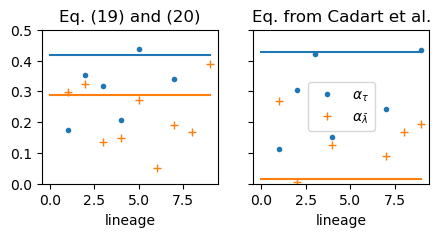

In [16]:
fig, axs = subplots(figsize=(5,2),ncols=2,sharey=true)


ax = axs[0]
ax.plot(dfa.ατ,"C0.",label=L"$\alpha_{\tau}$")
ax.plot(dfa.αλ,"C1+",label=L"$\alpha_{\bar{\lambda}}$")
ax.plot(ones(length(dfa.ατ)) .* mean(dfa.ατ),"C0-")
ax.plot(ones(length(dfa.ατ)) .* mean(dfa.αλ),"C1-")
ax.set_xlabel("lineage")
ax.set_title("Eq. (19) and (20)")
ax.set_ylim([0,0.5])



ax = axs[1]
ax.plot(dfa.ατ_c,"C0.",label=L"$\alpha_{\tau}$")
ax.plot(dfa.αλ_c,"C1+",label=L"$\alpha_{\bar{\lambda}}$")
ax.plot(ones(length(dfa.ατ)) .* mean(dfa.ατ_c),"C0-")
ax.plot(ones(length(dfa.ατ)) .* mean(dfa.αλ_c),"C1-")
ax.set_title("Eq. from Cadart et al.")
ax.set_xlabel("lineage")
ax.legend(frameon=true)


fig

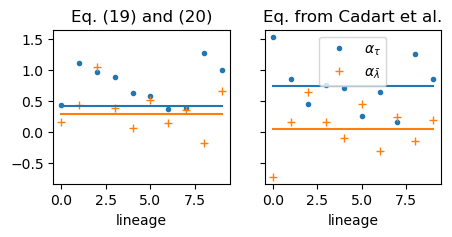

In [13]:
fig, axs = subplots(figsize=(5,2),ncols=2,sharey=true)


ax = axs[0]
ax.plot(dfa_sims.ατ,"C0.",label=L"$\alpha_{\tau}$")
ax.plot(dfa_sims.αλ,"C1+",label=L"$\alpha_{\bar{\lambda}}$")
ax.plot(ones(length(dfa.ατ)) .* mean(dfa.ατ),"C0-")
ax.plot(ones(length(dfa.ατ)) .* mean(dfa.αλ),"C1-")
ax.set_xlabel("lineage")
ax.set_title("Eq. (19) and (20)")
#ax.set_ylim([-3,30])



ax = axs[1]
ax.plot(dfa_sims.ατ_c,"C0.",label=L"$\alpha_{\tau}$")
ax.plot(dfa_sims.αλ_c,"C1+",label=L"$\alpha_{\bar{\lambda}}$")
ax.plot(ones(length(dfa_sims.ατ)) .* mean(dfa_sims.ατ_c),"C0-")
ax.plot(ones(length(dfa_sims.ατ)) .* mean(dfa_sims.αλ_c),"C1-")
ax.set_title("Eq. from Cadart et al.")
ax.set_xlabel("lineage")
ax.legend(frameon=true)
fig

In [38]:
fig, ax = subplots(figsize=(5,3))


# --------------------------------------
# plot alphas for data
ax.plot(alphas_gr,alphas_tau,".",label="data")
ax.plot(alphas_gr_sims,alphas_tau_sims,".",label="simulated data",fillstyle="none")

# and pooled
ax.plot(alpha_decomp(df_all_cells.gt,df_all_cells.x,df_all_cells.gr)
,alpha_decomp(df_all_cells.gr,df_all_cells.x,df_all_cells.gt),"C0+",markersize=10,label="data (pooled)")

# --------------------------------------
ax.plot(alpha_decomp(sims_cells.gt,sims_cells.x,sims_cells.gr)
,alpha_decomp(sims_cells.gr,sims_cells.x,sims_cells.gt),"C1+",markersize=10,label="sims (pooled)")

# --------------------------------------
# plot some guidelines
xrng = collect(-1:0.1:1)
ax.plot(xrng,1/2 .- xrng,"C4-",label="adder",lw=1)
ax.vlines([0],-1/2,1+1/2,linestyle="--",lw=0.7,color="C3")
ax.plot(xrng,zeros(length(xrng)),linestyle="--",lw=0.7,color="C3")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.legend(frameon=true)
ax.set_xlabel(L"$\alpha_{\bar{\lambda}}$ (remove time var.)")
ax.set_ylabel(L"$\alpha_{\tau}$ (remove growth var.)")

# for df in sims_cells
#     ax.plot()
# end

tight_layout()
savefig("./../figures/supp_condalpha.pdf",bbox_inches="tight")
fig



UndefVarError: UndefVarError: `alphas_gr` not defined

In [ ]:
function alpha_decomp(x,y,z) 
    -cov(x,y)/var(y) * mean(z) 
end


# Simpson's paradox

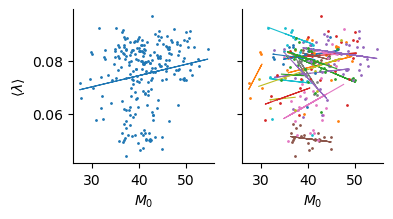

In [36]:

fig, (ax1,ax)= subplots(figsize=(4,2),ncols=2,sharex=true,sharey=true)



ax1.plot(df_all_cells.M0,df_all_cells.gr,".",markersize=2)
df = df_all_cells
X = hcat(ones(length(df.M0)),df.M0)
b = X\df.gr
xrange = min(df.M0...):0.1:max(df.M0...)
ax1.plot(X[:,2],X*b,color="C0",lw=0.8)


ax.set_xlabel(L"$M_0$")

ax1.set_ylabel(L"$\langle \lambda \rangle$")
ax1.spines["right"].set_visible(false)
ax1.spines["top"].set_visible(false)
#ax1.tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)
ax1.set_xlabel(L"$M_0$")


dfs = groupby(df_all_cells,:lineage)
for i in 1:length(dfs)
    df = dfs[i]
    ax.plot(df.M0,df.gr,".",color="C"*string(i),markersize=2)
    X = hcat(ones(length(df.M0)),df.M0)
    b = X\df.gr
    xrange = min(df.M0...):0.1:max(df.M0...)
    ax.plot(X[:,2],X*b,color="C"*string(i),lw=0.8)

end


ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
#gca().tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)


#savefig(NSF_CAREER_PATH*"/simpsons.pdf",bbox_inches="tight")

fig

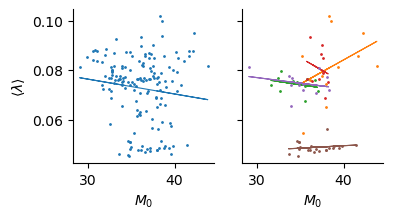

In [37]:

fig, (ax1,ax)= subplots(figsize=(4,2),ncols=2,sharex=true,sharey=true)




ax1.plot(sims_cells.M0,sims_cells.gr,".",markersize=2)
X = hcat(ones(length(sims_cells.M0)),sims_cells.M0)
b = X\sims_cells.gr
xrange = min(df.M0...):0.1:max(df.M0...)
ax1.plot(X[:,2],X*b,color="C0",lw=0.8)


ax.set_xlabel(L"$M_0$")

ax1.set_ylabel(L"$\langle \lambda \rangle$")
ax1.spines["right"].set_visible(false)
ax1.spines["top"].set_visible(false)
#ax1.tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)
ax1.set_xlabel(L"$M_0$")


for i in 1:5
    df = sims_cells[sims_cells.lineage .== lineages[i],:]
    ax.plot(df.M0,df.gr,".",color="C"*string(i),markersize=2)
    X = hcat(ones(length(df.M0)),df.M0)
    b = X\df.gr
    xrange = min(df.M0...):0.1:max(df.M0...)
    ax.plot(X[:,2],X*b,color="C"*string(i),lw=0.8)

end


ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
#gca().tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)


#savefig(NSF_CAREER_PATH*"/simpsons.pdf",bbox_inches="tight")
fig